1. Setup

1.1 Install Dependencies

In [90]:
!pip install tensorflow==2.8.0 tensorflow-gpu==2.8.0 opencv-python matplotlib

1.2 Import Dependencies

In [91]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [92]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

1.3 Set GPU Growth

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

1.4 Create Folder Structures

In [5]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [6]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

2. Collect Positives and Anchors

In [7]:
# http://vis-www.cs.umass.edu/lfw/

In [ ]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [ ]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

2.2 Collect Positive and Anchor Classes

In [8]:
# Import uuid library to generate unique image names
import uuid

In [9]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\b1fc951c-bcb0-11ec-8860-c03eba3a1da6.jpg'

In [ ]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame

In [ ]:
plt.imshow(frame[120:120+250,200:200+250, :])

3. Load and Preprocess Images

3.1 Get Image Directories

In [10]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [68]:
dir_test = anchor.as_numpy_iterator()

In [12]:
print(dir_test.next())

b'data\\anchor\\d7862787-bc7d-11ec-979c-c03eba3a1da6.jpg'


One cool thing I noticed about training on pairs is that there are quadratically many possible pairs of images to train the model on, making it hard to overfit. Say we have C examples each of E classes. Since there are C⋅E images total, the total number of possible pairs is given by Npairs=(C⋅E2)=(C⋅E)!2!(C⋅E−2)! For omniglot with its 20 examples of 964 training classes, this leads to 185,849,560 possible pairs, which is huge! However, the siamese network needs examples of both same and different class pairs. There are E examples per class, so there will be (E2) pairs for every class, which means there are Nsame=(E2)⋅C possible pairs with the same class - 183,160 pairs for omniglot. Even though 183,160 example pairs is plenty, it’s only a thousandth of the possible pairs, and the number of same-class pairs increases quadratically with E but only linearly with C. This is important because the siamese network should be given a 1:1 ratio of same-class and different-class pairs to train on - perhaps it implies that pairwise training is easier on datasets with lots of examples per class.

3.2 Preprocessing - Scale and Resize

In [2]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [4]:
img = preprocess(b'data\\anchor\\ea60f2a8-bc7d-11ec-aadf-c03eba3a1da6.jpg')

NameError: name 'tf' is not defined

In [15]:
img.numpy().max() 

0.902451

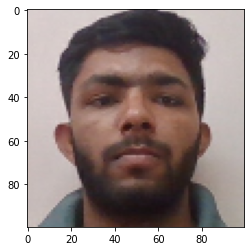

In [16]:
plt.imshow(img)

In [17]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

3.3 Create Labelled Dataset

In [18]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [19]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)


In [20]:
samples = data.as_numpy_iterator()

In [21]:
exampple = samples.next()

In [22]:
exampple

(b'data\\anchor\\05ea49ff-bc7e-11ec-aec7-c03eba3a1da6.jpg',
 b'data\\positive\\86594d73-bc7e-11ec-a952-c03eba3a1da6.jpg',
 1.0)

3.4 Build Train and Test Partition

In [23]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [24]:
res = preprocess_twin(*exampple)

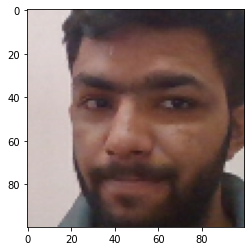

In [25]:
plt.imshow(res[1])

In [26]:
res[2]

1.0

In [27]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [28]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [29]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

4. Model Engineering

4.1 Build Embedding Layer

In [30]:
inp = Input(shape=(100,100,3), name='input_image')

In [31]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [32]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [33]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [34]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [35]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [36]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [37]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [38]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [39]:
embedding = make_embedding()

In [40]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

4.2 Build Distance Layer

In [41]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [42]:
l1 = L1Dist()

In [43]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

4.3 Make Siamese Model

In [44]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [45]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [46]:
siamese_layer = L1Dist()

In [47]:
distances = siamese_layer(inp_embedding, val_embedding)

In [48]:
classifier = Dense(1, activation='sigmoid')(distances)

In [49]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [50]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [51]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [52]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [53]:
siamese_model = make_siamese_model()

In [54]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

5. Training

5.1 Setup Loss and Optimizer

In [55]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [56]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

5.2 Establish Checkpoints

In [57]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

5.3 Build Train Step Function

In [58]:
test_batch = train_data.as_numpy_iterator()

In [59]:
batch_1 = test_batch.next()

In [60]:
X = batch_1[:2]

In [61]:
y = batch_1[2]

In [62]:
y

array([0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [63]:
tf.losses.BinaryCrossentropy??

In [64]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

5.4 Build Training Loop

In [65]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

# 5.5 Train the model

In [66]:
EPOCHS = 25

In [67]:
train(train_data, EPOCHS)


 Epoch 1/25
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 841s 31s/step

 Epoch 2/25
27/27 [==============================] - 839s 31s/step

 Epoch 3/25
27/27 [==============================] - 848s 31s/step

 Epoch 4/25
27/27 [==============================] - 850s 31s/step

 Epoch 5/25
27/27 [==============================] - 849s 31s/step

 Epoch 6/25
27/27 [==============================] - 853s 32s/step

 Epoch 7/25
27/27 [==============================] - 853s 32s/step

 Epoch 8/25
27/27 [==============================] - 847s 31s/step

 Epoch 9/25
27/27 [==============================] - 856s 32s/step

 Epoch 10/25
27/27 [==============================] - 1070s 40s/step

 Epoch 11/25
27/27 [==============================] - 1294s 48s/step

 Epoch 12/25
27/27 [==============================] - 1452s 54s/step

 Epoch 13/25
27/27 [===


6. Evaluate Model

6.1 Import Metrics

In [71]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

6.2 Make Predictions

In [72]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [73]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[6.9442613e-08],
       [1.0000000e+00],
       [3.7634537e-10],
       [1.0000000e+00],
       [9.9995184e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [4.9038396e-09],
       [1.0000000e+00],
       [9.9809766e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [2.0272344e-08],
       [1.0000000e+00],
       [1.0053657e-09]], dtype=float32)

[0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0]

In [75]:
y_true

array([0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0.],
      dtype=float32)

6.3 Calculate Metrics

In [76]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [77]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

6.4 Viz Results

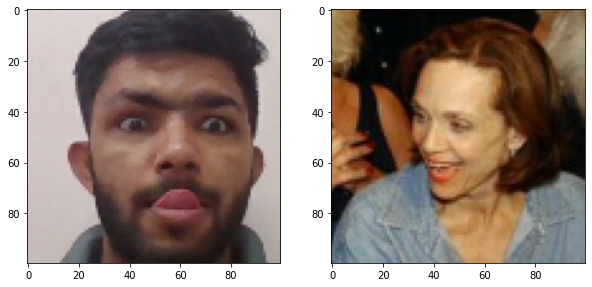

In [78]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

7. Save Model

In [79]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [80]:
L1Dist

__main__.L1Dist

In [81]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [82]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

array([[6.9442613e-08],
       [1.0000000e+00],
       [3.7634537e-10],
       [1.0000000e+00],
       [9.9995184e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [4.9038396e-09],
       [1.0000000e+00],
       [9.9809766e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [2.0272344e-08],
       [1.0000000e+00],
       [1.0053657e-09]], dtype=float32)

# View model summary
model.summary()

8. Real Time Test

In [83]:
application_data\verification_images

SyntaxError: unexpected character after line continuation character (2818603333.py, line 1)

In [84]:
os.listdir(os.path.join('application_data', 'verification_images'))

['4945cd02-bc7e-11ec-870b-c03eba3a1da6.jpg',
 '540ac8aa-bc7e-11ec-9656-c03eba3a1da6.jpg',
 '594a62d0-bc7e-11ec-ab5e-c03eba3a1da6.jpg',
 '639b258b-bc7e-11ec-946f-c03eba3a1da6.jpg',
 '6d0cfc61-bc7e-11ec-b2b5-c03eba3a1da6.jpg',
 '6d1b4ca6-bc7e-11ec-96fd-c03eba3a1da6.jpg',
 '6e4a8383-bc7e-11ec-86a6-c03eba3a1da6.jpg',
 '6e5fc8d2-bc7e-11ec-99ad-c03eba3a1da6.jpg',
 '6f77c40d-bc7e-11ec-b548-c03eba3a1da6.jpg',
 '6f8d3da2-bc7e-11ec-b870-c03eba3a1da6.jpg',
 '74f2276f-bc7e-11ec-b816-c03eba3a1da6.jpg',
 '761a6154-bc7e-11ec-8f85-c03eba3a1da6.jpg',
 '78b58c20-bc7e-11ec-9691-c03eba3a1da6.jpg',
 '798b8e7e-bc7e-11ec-9fc4-c03eba3a1da6.jpg',
 '7a565d9d-bc7e-11ec-9040-c03eba3a1da6.jpg',
 '7b1fc851-bc7e-11ec-b613-c03eba3a1da6.jpg',
 '7c5fc92f-bc7e-11ec-ab19-c03eba3a1da6.jpg',
 '7c6e480e-bc7e-11ec-b405-c03eba3a1da6.jpg',
 '7e757c77-bc7e-11ec-990f-c03eba3a1da6.jpg',
 '7f8b84fa-bc7e-11ec-b308-c03eba3a1da6.jpg',
 '82ec664b-bc7e-11ec-aaf2-c03eba3a1da6.jpg',
 '86594d73-bc7e-11ec-a952-c03eba3a1da6.jpg',
 '8a3292ad

In [85]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [86]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\4945cd02-bc7e-11ec-870b-c03eba3a1da6.jpg
application_data\verification_images\540ac8aa-bc7e-11ec-9656-c03eba3a1da6.jpg
application_data\verification_images\594a62d0-bc7e-11ec-ab5e-c03eba3a1da6.jpg
application_data\verification_images\639b258b-bc7e-11ec-946f-c03eba3a1da6.jpg
application_data\verification_images\6d0cfc61-bc7e-11ec-b2b5-c03eba3a1da6.jpg
application_data\verification_images\6d1b4ca6-bc7e-11ec-96fd-c03eba3a1da6.jpg
application_data\verification_images\6e4a8383-bc7e-11ec-86a6-c03eba3a1da6.jpg
application_data\verification_images\6e5fc8d2-bc7e-11ec-99ad-c03eba3a1da6.jpg
application_data\verification_images\6f77c40d-bc7e-11ec-b548-c03eba3a1da6.jpg
application_data\verification_images\6f8d3da2-bc7e-11ec-b870-c03eba3a1da6.jpg
application_data\verification_images\74f2276f-bc7e-11ec-b816-c03eba3a1da6.jpg
application_data\verification_images\761a6154-bc7e-11ec-8f85-c03eba3a1da6.jpg
application_data\verification_images\78b58c20-bc7e-11ec-9691-c03

In [87]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

8.2 OpenCV Real Time Verification

In [88]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

True
True
True
True
False
True
True
True


In [89]:
np.sum(np.squeeze(results) > 0.9)

21